In [124]:
import pandas as pd;
import numpy as np;
import tensorflow as tf;
import matplotlib.pyplot as plt;

In [125]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3070 Laptop GPU (UUID: GPU-209f9fbf-405c-7260-d4b7-3d55e8872723)


DATASET SOURCE:COINDESK.COM & CMCMARKETS.COM

In [126]:
data=pd.read_csv("./bitcoin_data.csv",parse_dates=["Date"],index_col="Date")
data.head(10)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566
2013-10-06,BTC,120.65533,121.33866,121.85216,120.55450
2013-10-07,BTC,121.79500,120.65533,121.99166,120.43199
2013-10-08,BTC,123.03300,121.79500,123.64016,121.35066
2013-10-09,BTC,124.04900,123.03300,124.78350,122.59266


In [127]:
price=pd.DataFrame(data["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
price.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [129]:
data.isnull().sum()

Currency               0
Closing Price (USD)    0
24h Open (USD)         0
24h High (USD)         0
24h Low (USD)          0
dtype: int64

In [130]:
import tensorflow as tf;
timestamps=price.index.to_numpy()
prices=price["Price"].to_numpy()

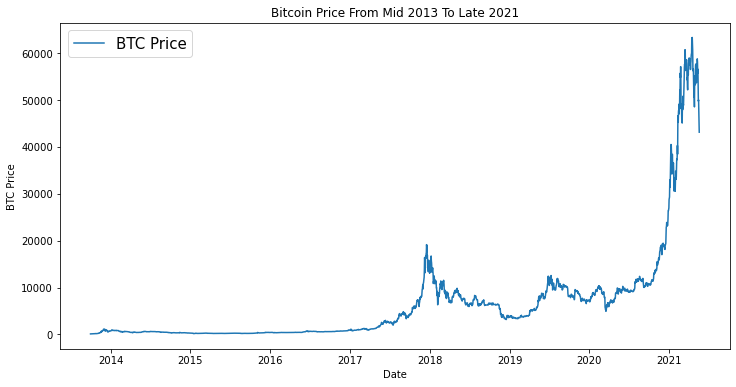

In [131]:
import matplotlib.pyplot as plt;
plt.figure(figsize=(12,6))
plt.plot(timestamps,prices,label="BTC Price")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.title("Bitcoin Price From Mid 2013 To Late 2021")
plt.legend(fontsize=15)
plt.show()

Splitting the data into train and test sets

In [132]:
split=int((0.8*len(price)))
x_train,y_train=timestamps[:split],prices[:split]
x_test,y_test=timestamps[split:],prices[split:]

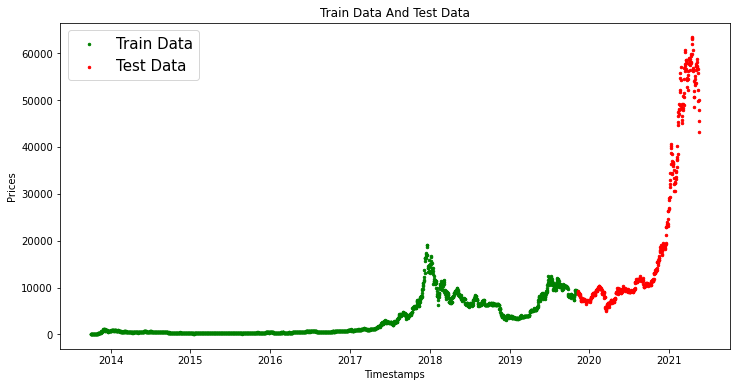

In [133]:
plt.figure(figsize=(12,6))
plt.scatter(x_train,y_train,s=6,color="green",label="Train Data")
plt.scatter(x_test,y_test,s=6,color="red",label="Test Data")
plt.xlabel("Timestamps")
plt.ylabel("Prices")
plt.title("Train Data And Test Data")
plt.legend(facecolor="white",fontsize=15)
plt.show()

In [134]:
def plot_time_series_graph(timestamps,values,start=0,format='.',end=None,label=None):
    plt.plot(timestamps[start:end],values[start:end],format,label=label)
    plt.xlabel("Timestamps")
    plt.ylabel("BTC Prices")
    plt.title("BTC Price vs Time")
    plt.grid("on")
    if label:
        plt.legend(fontsize=15)

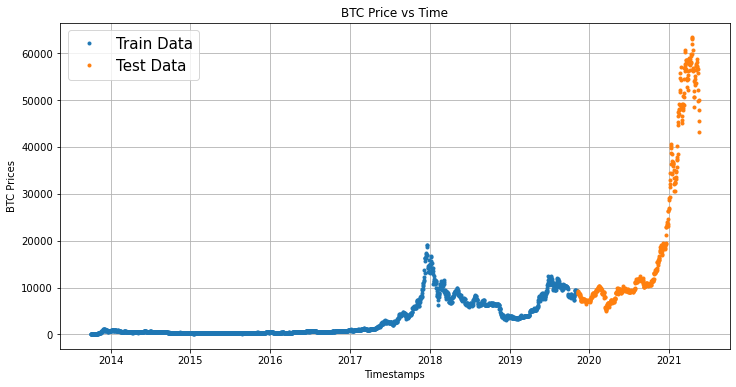

In [135]:
plt.figure(figsize=(12,6))
plot_time_series_graph(x_train,y_train,label="Train Data")
plot_time_series_graph(x_test,y_test,label="Test Data")

                      NAIVE FORECAST MODEL (BASELINE MODEL)

In [136]:
naive_forecast=y_test[:-1]
naive_forecast[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

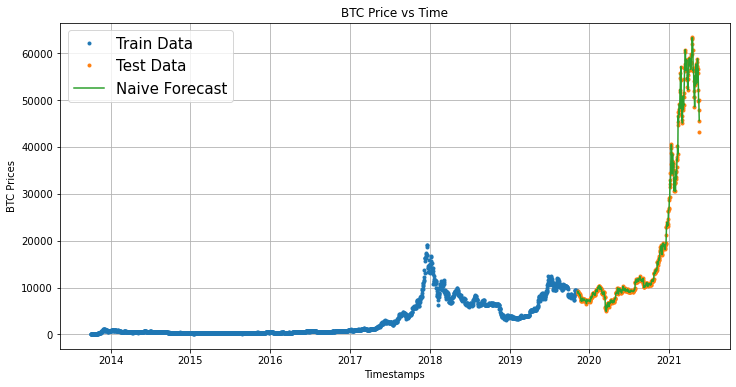

In [137]:
plt.figure(figsize=(12,6))
plot_time_series_graph(x_train,y_train,label="Train Data")
plot_time_series_graph(x_test,y_test,label="Test Data")
plot_time_series_graph(x_test[1:],y_test[:-1],format='-',label="Naive Forecast")

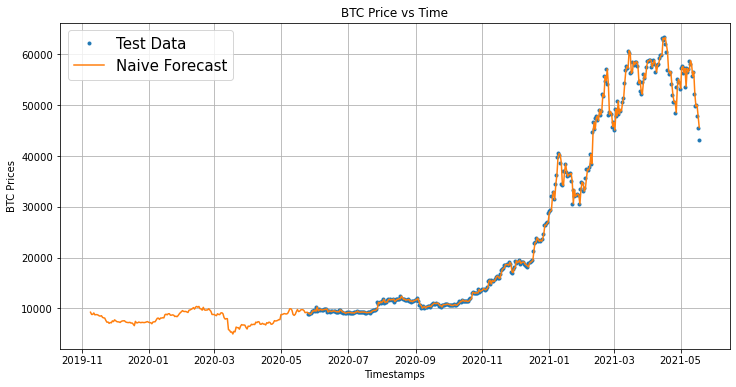

In [138]:
plt.figure(figsize=(12,6))
plot_time_series_graph(x_test,y_test,start=200,label="Test Data")
plot_time_series_graph(x_test[1:],y_test[:-1],format="-",label="Naive Forecast")

In [139]:
def mean_absolute_scaled_error_function(y_true,y_pred):
    mae=tf.reduce_mean(tf.abs(y_true-y_pred))
    mae_naive=tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
    return mae/mae_naive

In [140]:
def evaluate_predictions(y_true,y_pred):
    y_true=tf.cast(y_true,dtype=tf.float32) # WE ARE USING CAST TO MAKE SURE THE METRICS ARE BEING EVALUATED WITH FLOAT 32 bit values
    y_pred=tf.cast(y_pred,dtype=tf.float32)
    
    mae=tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse=tf.keras.metrics.mean_squared_error(y_true,y_pred)#EMPHASIS ON OUTLIERS ALL ERROR GETS SQUARED
    rmse=tf.sqrt(mse)
    mape=tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase=mean_absolute_scaled_error_function(y_true,y_pred)
    
    if mae.ndim>0:
        mae=tf.reduce_mean(mae)
        mse=tf.reduce_mean(mse)
        rmse=tf.reduce_mean(rmse)
        mape=tf.reduce_mean(mape)
        mase=tf.reduce_mean(mase)
    
    return {"mae":mae.numpy(),
            "mse":mse.numpy(),
            "rmse":rmse.numpy(),
            "mape":mape.numpy(),
            "mase":mase.numpy()}

In [141]:
naive_results=evaluate_predictions(y_true=y_test[1:],y_pred=y_test[:-1])
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

CREATING WINDOWS AND HORIZON TO MAKE THIS INTO A SUPERVISED LEARNING PROBLEM

In [142]:
HORIZON_VALUE=1 #Horizon is set to 1 so that we take one step at a time and window is set to 7 that represents 7 days in a week 
WINDOW_SIZE_VALUE=7 #for example window =30 means 30 days in a month thus it plays an important role in time series forecasting

In [143]:
def get_windows(x,horizon):
    return x[:,:-horizon],x[:,-horizon:]

THIS MEANS suppose input=[1,2,3,4,5,6,7]->label=7 it outputs=[1,2,3,4,5,6],[7]

In [144]:
def create_windows(x,window_size=7,horizon=1):
    window_step=np.expand_dims(np.arange(window_size+horizon),axis=0)
    window_indexes=window_step+np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T
    windowed_array=x[window_indexes]
    windows,labels=get_windows(windowed_array,horizon=horizon)
    return windows,labels

WE GONNA MAKE THE WINDOWS OUT OF THE TARGET VARIBLE THAT IS PRICE! REMEMBER THAT!

In [145]:
full_windows,full_labels=create_windows(prices,window_size=WINDOW_SIZE_VALUE,horizon=HORIZON_VALUE)
for i in range(7):
    print(f"window {full_windows[i]}----->label {full_labels[i]}")

window [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]----->label [123.033]
window [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]----->label [124.049]
window [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]----->label [125.96116]
window [118.67466 121.33866 120.65533 121.795   123.033   124.049   125.96116]----->label [125.27966]
window [121.33866 120.65533 121.795   123.033   124.049   125.96116 125.27966]----->label [125.9275]
window [120.65533 121.795   123.033   124.049   125.96116 125.27966 125.9275 ]----->label [126.38333]
window [121.795   123.033   124.049   125.96116 125.27966 125.9275  126.38333]----->label [135.24199]


TURNING WINDOWS INTO TRAIN AND TEST SETS!

In [146]:
def train_test_splits(windows,labels,split_size=0.2):
    split=int(len(windows)*(1-split_size))
    train_windows=windows[:split]
    train_labels=labels[:split]
    test_windows=windows[split:]
    test_labels=labels[split:]
    return train_windows,test_windows,train_labels,test_labels

In [147]:
train_windows,test_windows,train_labels,test_labels=train_test_splits(full_windows,full_labels)

CREATING A MODEL CHECKPOINT!

In [148]:
import os;
def create_model_checkpoint(model_name,save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),verbose=0,save_best_only=True)

                    MODEL 1 :DENSE MODEL (WINDOW 7 HORIZON 1)

In [149]:
import tensorflow as tf;
from keras import layers;

In [150]:
tf.random.set_seed(42)
model_1=tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON_VALUE)
],name="model_1_Dense")
model_1.compile(loss="mae",optimizer="adam",metrics=["mae"])
model_1.fit(train_windows,train_labels,epochs=100,batch_size=128,callbacks=[create_model_checkpoint(model_name=model_1.name)],
            validation_data=(test_windows,test_labels),verbose=1)

Epoch 1/100
18/18 [==============================] - 0s 7ms/step - loss: 908.7355 - mae: 908.7355 - val_loss: 2464.6182 - val_mae: 2464.6182
INFO:tensorflow:Assets written to: model_experiments\model_1_Dense\assets
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 264.7428 - mae: 264.7428 - val_loss: 1223.9349 - val_mae: 1223.9349
INFO:tensorflow:Assets written to: model_experiments\model_1_Dense\assets
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 166.0673 - mae: 166.0673 - val_loss: 842.2179 - val_mae: 842.2179
INFO:tensorflow:Assets written to: model_experiments\model_1_Dense\assets
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 152.3679 - mae: 152.3679 - val_loss: 718.7227 - val_mae: 718.7227
INFO:tensorflow:Assets written to: model_experiments\model_1_Dense\assets
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 127.2495 - mae: 127.2495 - val_loss: 663.4590 - val_mae: 663.4590
INFO:

In [151]:
model_1=tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 862us/step - loss: 564.4296 - mae: 564.4296


[564.4295654296875, 564.4295654296875]

In [152]:
def make_predictions(model,input_data):
    forecast=model.predict(input_data)
    return tf.squeeze(forecast)

In [153]:
model_1_preds=make_predictions(model_1,test_windows)
model_1_results=evaluate_predictions(y_true=tf.squeeze(test_labels),y_pred=model_1_preds)
model_1_results

{'mae': 564.4296,
 'mse': 1146537.4,
 'rmse': 1070.7649,
 'mape': 2.5199203,
 'mase': 0.9915465}

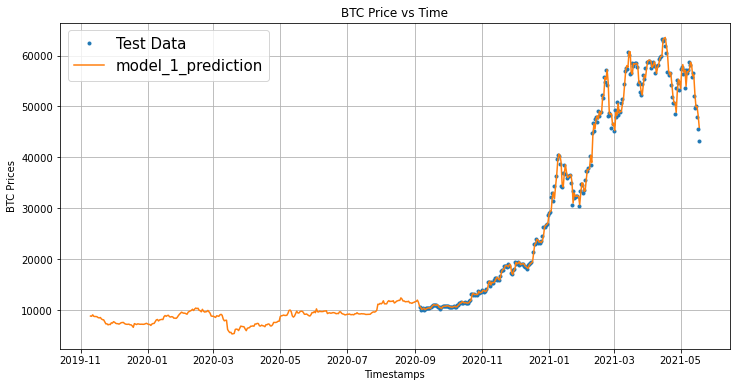

In [154]:
offset=300
plt.figure(figsize=(12,6))
plot_time_series_graph(timestamps=x_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series_graph(timestamps=x_test[-len(test_windows):],values=model_1_preds,format='-',label="model_1_prediction")

In [155]:
WINDOW_SIZE_VALUE=30
HORIZON_VALUE=1

In [156]:
full_windows,full_labels=create_windows(prices,WINDOW_SIZE_VALUE,HORIZON_VALUE)
train_windows,test_windows,train_labels,test_labels=train_test_splits(full_windows,full_labels)

In [157]:
tf.random.set_seed(42)
model_2=tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON_VALUE)
],name="model_2_Dense")
model_2.compile(loss="mae",optimizer="adam",metrics=["mae"])
model_2.fit(train_windows,train_labels,epochs=100,batch_size=128,callbacks=[create_model_checkpoint(model_name=model_2.name)],
            validation_data=(test_windows,test_labels))

Epoch 1/100
18/18 [==============================] - 0s 7ms/step - loss: 675.0560 - mae: 675.0560 - val_loss: 1385.9530 - val_mae: 1385.9530
INFO:tensorflow:Assets written to: model_experiments\model_2_Dense\assets
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 206.2850 - mae: 206.2850 - val_loss: 1326.8442 - val_mae: 1326.8442
INFO:tensorflow:Assets written to: model_experiments\model_2_Dense\assets
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 180.6766 - mae: 180.6766 - val_loss: 992.0082 - val_mae: 992.0082
INFO:tensorflow:Assets written to: model_experiments\model_2_Dense\assets
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 159.9355 - mae: 159.9355 - val_loss: 1264.8793 - val_mae: 1264.8793
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 170.7216 - mae: 170.7216 - val_loss: 998.4106 - val_mae: 998.4106
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 149.

In [158]:
model_2=tf.keras.models.load_model("model_experiments/model_2_Dense/")
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 590.4879 - mae: 590.4879


[590.4879150390625, 590.4879150390625]

In [159]:
model_2_preds=make_predictions(model_2,input_data=test_windows)
model_2_results=evaluate_predictions(y_true=tf.squeeze(test_labels),y_pred=model_2_preds)
model_2_results

{'mae': 590.4879,
 'mse': 1226906.0,
 'rmse': 1107.6578,
 'mape': 2.7376065,
 'mase': 1.0321786}

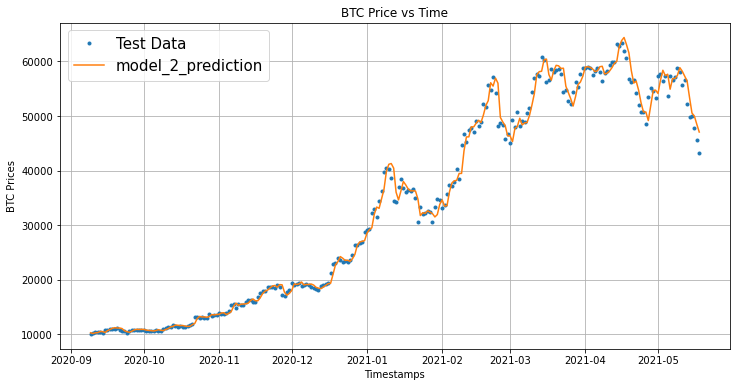

In [160]:
offset=300
plt.figure(figsize=(12,6))
plot_time_series_graph(timestamps=x_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series_graph(timestamps=x_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_prediction")

In [161]:
WINDOW_SIZE_VALUE=30
HORIZON_VALUE=7

In [162]:
full_windows,full_labels=create_windows(prices,WINDOW_SIZE_VALUE,HORIZON_VALUE)
train_windows,test_windows,train_labels,test_labels=train_test_splits(full_windows,full_labels)

In [163]:
tf.random.set_seed(42)
model_3=tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON_VALUE)
],name="model_3_Dense")
model_3.compile(loss="mae",optimizer="adam",metrics=["mae"])
model_3.fit(train_windows,train_labels,epochs=100,batch_size=128,callbacks=[create_model_checkpoint(model_name=model_3.name)],
            validation_data=(test_windows,test_labels))

Epoch 1/100
18/18 [==============================] - 0s 7ms/step - loss: 1219.2057 - mae: 1219.2057 - val_loss: 3444.7432 - val_mae: 3444.7432
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 462.3819 - mae: 462.3819 - val_loss: 2133.7336 - val_mae: 2133.7336
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 354.3758 - mae: 354.3758 - val_loss: 1800.2960 - val_mae: 1800.2960
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 313.8343 - mae: 313.8343 - val_loss: 1542.3290 - val_mae: 1542.3290
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 284.5406 - mae: 284.5406 - val_loss: 1601.1099 - val_mae: 1601.10

In [164]:
model_3=tf.keras.models.load_model("model_experiments/model_3_Dense/")
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 898us/step - loss: 1192.0691 - mae: 1192.0691


[1192.069091796875, 1192.069091796875]

In [165]:
model_3_preds=make_predictions(model_3,input_data=test_windows)
model_3_results=evaluate_predictions(y_true=tf.squeeze(test_labels),y_pred=model_3_preds)
model_3_results

{'mae': 1192.0692,
 'mse': 5004384.5,
 'rmse': 1378.3088,
 'mape': 5.496029,
 'mase': 2.1212204}

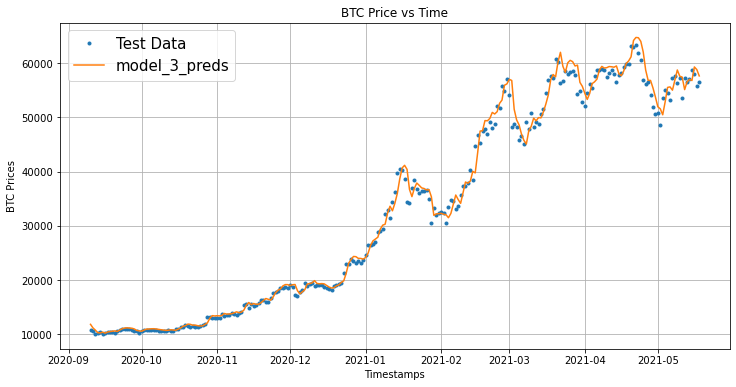

In [166]:
offset=300
plt.figure(figsize=(12,6))
plot_time_series_graph(timestamps=x_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series_graph(timestamps=x_test[-len(test_windows):],values=tf.reduce_mean(model_3_preds,axis=1),start=offset,format='-',label="model_3_preds")


<AxesSubplot:>

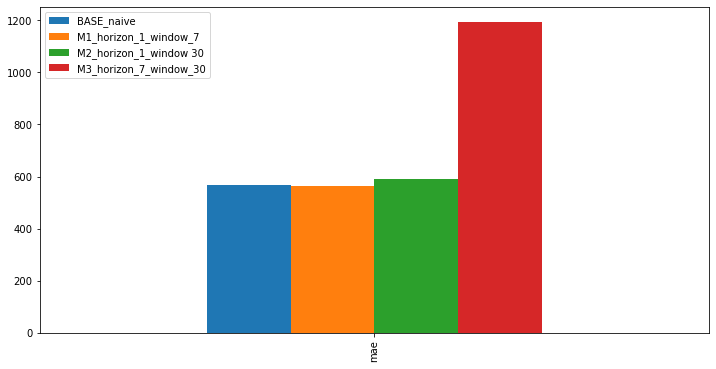

In [167]:
pd.DataFrame({"BASE_naive":naive_results["mae"],
              "M1_horizon_1_window_7":model_1_results["mae"],
              "M2_horizon_1_window 30":model_2_results["mae"],
              "M3_horizon_7_window_30":model_3_results["mae"]},index=["mae"]).plot(kind="bar",figsize=(12,6))

LOWER IS BETTER AND SEEMS LIKE HORIZON 1 AND WINDOW 7 MODEL WORKS BEST SO IM GOING TO STICK WITH IT!

                                    MODEL 4:CONV1D MODEL 
                RESHAPING THE MODEL BY USING LAMBDA LAYER IS NECESSARY

In [168]:
HORIZON_VALUE=1
WINDOW_SIZE_VALUE=7

In [169]:
full_windows,full_labels=create_windows(prices,window_size=WINDOW_SIZE_VALUE,horizon=HORIZON_VALUE)
train_windows,test_windows,train_labels,test_labels=train_test_splits(full_windows,full_labels)

In [170]:
tf.random.set_seed(42)
model_4=tf.keras.Sequential([
    layers.Lambda(lambda x:tf.expand_dims(x,axis=1)),
    layers.Conv1D(128,5,padding="causal",activation="relu"),
    layers.Dense(HORIZON_VALUE)
],name="model_4_Conv1D")
model_4.compile(loss="mae",optimizer="adam",metrics=["mae"])
model_4.fit(train_windows,train_labels,epochs=100,batch_size=128,validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)],verbose=1)

Epoch 1/100
18/18 [==============================] - 0s 8ms/step - loss: 1207.3829 - mae: 1207.3829 - val_loss: 2320.5935 - val_mae: 2320.5935
INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 316.2179 - mae: 316.2179 - val_loss: 1467.2781 - val_mae: 1467.2781
INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 192.6775 - mae: 192.6775 - val_loss: 1164.7834 - val_mae: 1164.7834
INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 177.3532 - mae: 177.3532 - val_loss: 981.7596 - val_mae: 981.7596
INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 172.3293 - mae: 172.3293 - val_loss: 961.3768 - val_mae: 961.37

In [171]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_14 (Lambda)           (None, 1, 7)              0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 128)            4608      
_________________________________________________________________
dense_88 (Dense)             (None, 1, 1)              129       
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [172]:
model_4=tf.keras.models.load_model("model_experiments/model_4_Conv1D/")
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 568.5081 - mae: 568.5081


[568.508056640625, 568.508056640625]

In [173]:
model_4_preds=make_predictions(model_4,input_data=test_windows)
model_4_results=evaluate_predictions(y_true=tf.squeeze(test_labels),y_pred=model_4_preds)
model_4_results

{'mae': 568.5081,
 'mse': 1171916.9,
 'rmse': 1082.551,
 'mape': 2.5474138,
 'mase': 0.9987113}

<AxesSubplot:>

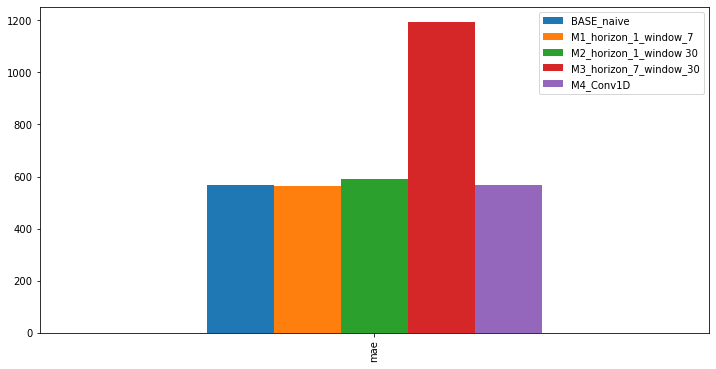

In [174]:
pd.DataFrame({"BASE_naive":naive_results["mae"],
              "M1_horizon_1_window_7":model_1_results["mae"],
              "M2_horizon_1_window 30":model_2_results["mae"],
              "M3_horizon_7_window_30":model_3_results["mae"],
              "M4_Conv1D":model_4_results["mae"]},index=["mae"]).plot(kind="bar",figsize=(12,6))

                                        MODEL 5: RNN (LSTM)

In [175]:
tf.random.set_seed(42)
inputs=layers.Input(shape=(WINDOW_SIZE_VALUE,),dtype=tf.float32)
x=layers.Lambda(lambda x:tf.expand_dims(x,axis=1))(inputs)
x=layers.Bidirectional(layers.LSTM(128,activation="relu"))(x)
x=layers.Dense(128,activation="relu")(x)
outputs=layers.Dense(HORIZON_VALUE)(x)
model_5=tf.keras.Model(inputs,outputs,name="model_5_lstm")
model_5.compile(loss="mae",optimizer="adam",metrics=["mae"])

In [176]:
model_5.fit(train_windows,train_labels,epochs=100,batch_size=128,validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)],verbose=1)

Epoch 1/100
18/18 [==============================] - 2s 23ms/step - loss: 1617.5868 - mae: 1617.5868 - val_loss: 3141.5459 - val_mae: 3141.5459
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 316.2223 - mae: 316.2223 - val_loss: 1297.0160 - val_mae: 1297.0160
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 192.8674 - mae: 192.8674 - val_loss: 967.5300 - val_mae: 967.5300
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 170.0711 - mae: 170.0711 - val_loss: 1016.9905 - val_mae: 1016.9905
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 171.1750 - mae: 171.1750 - val_loss: 931.2467 - val_mae: 931.2467
INFO:tensorflow:Assets written to: model_experiments\model_5_lstm\assets
Epoc

In [177]:
model_5=tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 566.4580 - mae: 566.4580


[566.4580078125, 566.4580078125]

In [178]:
model_5_preds=make_predictions(model_5,input_data=test_windows)
model_5_results=evaluate_predictions(y_true=tf.squeeze(test_labels),y_pred=model_5_preds)
model_5_results

{'mae': 566.458,
 'mse': 1167174.0,
 'rmse': 1080.3583,
 'mape': 2.5433893,
 'mase': 0.9951098}

                                MODEL 6:GRU (GATED RECCURENT UNIT) MODEL

In [179]:
tf.random.set_seed(42)
model_6=tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=1)),
    tf.keras.layers.GRU(128,activation="relu"),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON_VALUE)
],name="model_8_GRU")
model_6.compile(loss="mae",optimizer="adam",metrics=["mae"])
model_6.fit(train_windows,train_labels,epochs=100,batch_size=128,validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_6.name)],verbose=0)

INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU\assets
INFO:tensorflow:Assets written to: model_experiments\model_8_GRU

In [180]:
model_6=tf.keras.models.load_model("model_experiments/model_GRU/")
model_6.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 865us/step - loss: 563.3403 - mae: 563.3403


[563.3402709960938, 563.3402709960938]

In [228]:
model_6_preds=make_predictions(model_6,input_data=test_windows)
model_6_results=evaluate_predictions(y_true=tf.squeeze(test_labels),y_pred=model_6_preds)

In [181]:
reward_1=25
reward_2=12.5
reward_3=6.25

reward_1_datetime=np.datetime64("2012-11-28")
reward_2_datetime=np.datetime64("2016-07-09")
reward_3_datetime=np.datetime64("2020-05-11")

In [182]:
reward_2_days=(reward_2_datetime-price.index[0]).days
reward_3_days=(reward_3_datetime-price.index[0]).days
reward_2_days,reward_3_days

(1012, 2414)

In [183]:

bitcoin_prices_block = price.copy()
bitcoin_prices_block["reward"] = None


bitcoin_prices_block.iloc[:reward_2_days, -1] = reward_1
bitcoin_prices_block.iloc[reward_2_days:reward_3_days, -1] = reward_2
bitcoin_prices_block.iloc[reward_3_days:, -1] = reward_3
bitcoin_prices_block.head(10)

,Price,reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25
2013-10-06,120.65533,25
2013-10-07,121.79500,25
2013-10-08,123.03300,25
2013-10-09,124.04900,25


In [184]:
windowed_bitcoin_prices=bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE_VALUE):
    windowed_bitcoin_prices[f"Price+{i+1}"]=windowed_bitcoin_prices["Price"].shift(periods=i+1)
windowed_bitcoin_prices.head(10)

,Price,reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [185]:
X=windowed_bitcoin_prices.dropna().drop("Price",axis=1).astype(np.float32)
Y=windowed_bitcoin_prices.dropna()["Price"].astype(np.float32)
X.head()

,reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [186]:
split = int(len(X) * 0.8)
x_train, y_train = X[:split], X[:split]
x_test, y_test = X[split:], Y[split:]
len(x_train), len(y_train), len(x_test), len(y_test)

(2224, 2224, 556, 556)

In [187]:
tf.random.set_seed(42)
model_7=tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON_VALUE)
],name="model_7_dense_multivariate")
model_7.compile(loss="mae",optimizer="adam",metrics=["mae"])

In [188]:
model_7.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_test,y_test),
            callbacks=[create_model_checkpoint(model_7.name)],verbose=1)

Epoch 1/100
18/18 [==============================] - 0s 7ms/step - loss: 907.6693 - mae: 907.6693 - val_loss: 2068.8083 - val_mae: 2068.8083
INFO:tensorflow:Assets written to: model_experiments\model_GRU\assets
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 525.6135 - mae: 525.6135 - val_loss: 993.0799 - val_mae: 993.0799
INFO:tensorflow:Assets written to: model_experiments\model_GRU\assets
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 497.5010 - mae: 497.5010 - val_loss: 1019.7528 - val_mae: 1019.7528
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 493.4314 - mae: 493.4314 - val_loss: 1042.9901 - val_mae: 1042.9901
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 492.0501 - mae: 492.0501 - val_loss: 1069.8339 - val_mae: 1069.8339
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 491.2018 - mae: 491.2018 - val_loss: 1177.3999 - val_mae: 1177.3999
Epoch 7/100
18/1

In [191]:
model_7=tf.keras.models.load_model("model_experiments/model_7_dense_multivariate/")
model_7.evaluate(x_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 993.4256 - mae: 993.4256


[993.4255981445312, 993.4255981445312]

In [192]:
model_7_preds=make_predictions(model_7,input_data=x_test)
model_7_results=evaluate_predictions(y_true=y_test,y_pred=model_7_preds)
model_7_results

{'mae': 993.4256,
 'mse': 3291787.5,
 'rmse': 1814.3284,
 'mape': 4.479973,
 'mase': 1.7451736}

In [193]:
x_train.shape

(2224, 8)

In [194]:
model_7.summary()

Model: "model_6_dense_multivariate"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 17,793
Trainable params: 17,793
Non-trainable params: 0
_________________________________________________________________


                                  MODEL 7:CREATING A TRIBRID MODEL(WINDOWS,BLOCK REWARDS AND DAYS OF WEEK)

In [195]:
data["day_of_week"]=data.index.dayofweek
data.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),day_of_week
Date,,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349,1
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383,2
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833,3
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816,4
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566,5


In [196]:
windowed_bitcoin_prices["day_of_week"]=windowed_bitcoin_prices.index.dayofweek

In [197]:
full_windows,full_labels=create_windows(prices)
train_windows , test_windows , train_labels , test_labels = train_test_splits(full_windows , full_labels)
X=windowed_bitcoin_prices.dropna().drop(["Price"],axis=1).astype(np.float32)
Y=windowed_bitcoin_prices.dropna()["Price"].astype(np.float32)
day_of_week=windowed_bitcoin_prices.dropna()['day_of_week'].to_list()

In [198]:
split=int(0.8*len(X))
train_block_rewards,test_block_rewards=X[:split],X[split:]
train_days,test_days=day_of_week[:split],day_of_week[split:]
len(train_block_rewards),len(test_block_rewards),len(train_days),len(test_days)

(2224, 556, 2224, 556)

In [199]:
train_data_tribrid=tf.data.Dataset.from_tensor_slices((train_windows,
                                                      train_block_rewards,
                                                      train_days))
train_labels_tribrid=tf.data.Dataset.from_tensor_slices(train_labels)


test_data_tribrid=tf.data.Dataset.from_tensor_slices((test_windows,
                                                      test_block_rewards,
                                                      test_days))
test_labels_tribrid=tf.data.Dataset.from_tensor_slices(test_labels)

train_data_ds=tf.data.Dataset.zip((train_data_tribrid,train_labels_tribrid)).batch(128).prefetch(tf.data.AUTOTUNE)
test_data_ds=tf.data.Dataset.zip((test_data_tribrid,test_labels_tribrid)).batch(128).prefetch(tf.data.AUTOTUNE)
train_data_ds,test_data_ds

(<PrefetchDataset shapes: (((None, 7), (None, 9), (None,)), (None, 1)), types: ((tf.float64, tf.float32, tf.int32), tf.float64)>,
 <PrefetchDataset shapes: (((None, 7), (None, 9), (None,)), (None, 1)), types: ((tf.float64, tf.float32, tf.int32), tf.float64)>)

In [200]:
#building the tribrid model!
input_windows=tf.keras.layers.Input(shape=(7,),dtype=tf.float64,name="window_inputs")
exp_layer1=tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=1))(input_windows)
conv1=tf.keras.layers.Conv1D(filters=32,kernel_size=5,padding="causal",activation="relu")(exp_layer1)
window_model=tf.keras.Model(input_windows,conv1,name="window_model")

input_blocks=tf.keras.Input(shape=(9,),dtype=tf.float64,name="block_rewards_inputs")
exp_layer2=tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=1))(input_blocks)
conv2=tf.keras.layers.Conv1D(filters=32,kernel_size=5,padding="causal",activation="relu")(exp_layer2)
block_model=tf.keras.Model(input_blocks,conv2,name="block_model")

input_days=tf.keras.layers.Input(shape=(1,),dtype=tf.int32,name="days_input")
exp_layer3=tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=1))(input_days)
dense=tf.keras.layers.Dense(128,activation="relu")(exp_layer3)
days_model=tf.keras.Model(input_days,dense,name="days_model")

#concatenating the inputs!
concat=tf.keras.layers.Concatenate(name="Combined_outputs")([window_model.output,
                                                      block_model.output,
                                                      days_model.output])
#creating the output layer
dropout=tf.keras.layers.Dropout(0.5)(concat)
output_layer=tf.keras.layers.Dense(1,activation="linear")(dropout)

tribrid_model=tf.keras.Model(inputs=[window_model.input,
                                     block_model.input,
                                     days_model.input],outputs=output_layer,name="tribrid_model")

tribrid_model.summary()

Model: "tribrid_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
window_inputs (InputLayer)      [(None, 7)]          0                                            
__________________________________________________________________________________________________
block_rewards_inputs (InputLaye [(None, 9)]          0                                            
__________________________________________________________________________________________________
days_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 1, 7)         0           window_inputs[0][0]              
______________________________________________________________________________________

In [201]:
tribrid_model.compile(loss="mae",optimizer=tf.keras.optimizers.Adam(),metrics=["mae"])
tribrid_model.fit(train_data_ds,epochs=100,validation_data=test_data_ds,verbose=1,
                  callbacks=[create_model_checkpoint(model_name=tribrid_model.name)])

Epoch 1/100
18/18 [==============================] - 1s 14ms/step - loss: 3248.9028 - mae: 3248.9028 - val_loss: 18144.4473 - val_mae: 18144.4473
INFO:tensorflow:Assets written to: model_experiments\tribrid_model\assets
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 2180.9155 - mae: 2180.9155 - val_loss: 11792.0986 - val_mae: 11792.0986
INFO:tensorflow:Assets written to: model_experiments\tribrid_model\assets
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 1190.6482 - mae: 1190.6482 - val_loss: 5216.7368 - val_mae: 5216.7368
INFO:tensorflow:Assets written to: model_experiments\tribrid_model\assets
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 736.5026 - mae: 736.5026 - val_loss: 1330.9083 - val_mae: 1330.9083
INFO:tensorflow:Assets written to: model_experiments\tribrid_model\assets
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 753.4719 - mae: 753.4719 - val_loss: 1192.9438 - val_mae

In [202]:
model_8=tf.keras.models.load_model("model_experiments/tribrid_model/")
model_8.evaluate(test_data_ds)

5/5 [==============================] - 0s 3ms/step - loss: 1122.8456 - mae: 1122.8456


[1122.8455810546875, 1122.8455810546875]

In [204]:
model_8_preds=make_predictions(model_8,input_data=test_data_ds)
model_8_results=evaluate_predictions(y_true=test_labels,y_pred=model_7_preds)
model_8_results

{'mae': 17132.172,
 'mse': 616878660.0,
 'rmse': 23774.654,
 'mape': 113.17698,
 'mase': 30.096485}

CREATING AN ENSEMBLE MODEL AND TRAINING WITH WHOLE DATA TO MAKE FUTURE FORECASTS

In [205]:
x_full=windowed_bitcoin_prices.drop(["Price","reward","day_of_week"],axis=1).dropna().to_numpy()
y_full=windowed_bitcoin_prices.dropna()["Price"].to_numpy()
full_ds=tf.data.Dataset.from_tensor_slices((x_full,y_full)).batch(128).prefetch(tf.data.AUTOTUNE)
full_ds

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [206]:
def create_ensemble_models(horizon=HORIZON_VALUE,
                        dataset=full_ds,
                        num_iter=10,
                        num_of_epochs=100,
                        loss_fns=['mae','mse','mape']):
    ensemble_models=[]
    for i in range(num_iter):
        for loss_functions in loss_fns:
            print(f"Optimizing Model by reducing: {loss_functions} for {num_of_epochs} epochs , model_number{i}")
            
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(128,kernel_initializer='he_normal',activation="relu"),
                tf.keras.layers.Dense(128,kernel_initializer='he_normal',activation="relu"),
                tf.keras.layers.Dense(HORIZON_VALUE)
            ])
            
            model.compile(loss=loss_functions,optimizer=tf.keras.optimizers.Adam(),metrics=['mae','mse'])
            
            #NOW WE GOING TO INTRODUCE EARLY STOPPING TO OUR MODEL SO THAT IT STOPS WHEN MODEL DOESNT IMPROVE PERFORMANCE IN A SERIES
            #ALSO WE ARE GOING TO INTRODUCE LR ON PLATEAU FUNCTION TO REDUCE THE LEARNING RATE WHEN THE MODEL IS NOT IMPROVING!
            
            model.fit(dataset,epochs=num_of_epochs,verbose=0,callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='loss',patience=200,restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",patience=100,verbose=1)
            ])
            
            ensemble_models.append(model)
            
    return ensemble_models        

In [214]:
ensemble_model=create_ensemble_models(num_iter=5,num_of_epochs=1000,horizon=1)

Optimizing Model by reducing: mae for 1000 epochs , model_number0

Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00300: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing Model by reducing: mse for 1000 epochs , model_number0

Epoch 00121: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00391: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing Model by reducing: mape for 1000 epochs , model_number0

Epoch 00192: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00294: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00419: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00632: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00794: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00895: ReduceLROnPlateau reducing learning rate to 1.0000

In [215]:
def make_future_forecast(values,model_list,into_future,window_size):
    future_forecast=[]
    last_window=values[-window_size:]
    for _ in range(into_future):
        for model in model_list:
            future_pred=model.predict(tf.expand_dims(last_window,axis=0))
            
            print(f"Predicting for:\n{last_window} --> prediction: {tf.squeeze(future_pred).numpy()}\n")
            future_forecast.append(tf.squeeze(future_pred).numpy())
            
            last_window=np.append(last_window,future_pred)[-window_size:]
    return future_forecast

In [216]:
future_forecast=make_future_forecast(y_full,ensemble_model,into_future=14,window_size=7)

Predicting for:
[56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] --> prediction: 56233.75390625

Predicting for:
[52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 56233.75390625] --> prediction: 53160.69140625

Predicting for:
[49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 56233.75390625 53160.69140625] --> prediction: 49305.546875

Predicting for:
[50032.69313676 47885.62525472 45604.61575361 43144.47129086
 56233.75390625 53160.69140625 49305.546875  ] --> prediction: 50734.484375

Predicting for:
[47885.62525472 45604.61575361 43144.47129086 56233.75390625
 53160.69140625 49305.546875   50734.484375  ] --> prediction: 46283.859375

Predicting for:
[45604.61575361 43144.47129086 56233.75390625 53160.69140625
 49305.546875   50734.484375   46283.859375  ] --> prediction: 46665.7890625

Predicting for:
[43144.47129086 56233.75390625 53160.69140625 49305.546

In [217]:
HORIZON_VALUE=1
WINDOW_SIZE_VALUE=7

In [218]:
def get_models(horizon=HORIZON_VALUE):
    model=tf.keras.Sequential([
        tf.keras.layers.Dense(128,activation="relu"),
        tf.keras.layers.Dense(128,activation="relu"),
        tf.keras.layers.Dense(HORIZON_VALUE)
    ])
    model.compile(loss=tf.keras.losses.mae,optimizer=tf.keras.optimizers.Adam())
    return model

In [219]:
full_windows,full_labels=create_windows(prices,window_size=WINDOW_SIZE_VALUE,horizon=HORIZON_VALUE)

In [220]:
def pred_model_and_run(values,X,model,into_future,window_size,horizon,epochs):
    #in this model we train model everytime a new prediction has been made!
    last_window=values[-window_size:]
    x_full=X
    y_full=values
    for _ in range(into_future):
        model.fit(x_full,y_full,epochs=epochs,verbose=0)
        future_pred=model.predict(tf.expand_dims(last_window,axis=0))
        
        print(f"Predicting for:\n {last_window}-->Predicted: {tf.squeeze(future_pred).numpy()}\n")
        
        future_forecast.append(tf.squeeze(future_pred).numpy())
        
        for i in range (0,len(x_full)):
            x=x_full[i][1:]
            y=y_full[1:]
            X=np.append(x,future_pred)
            values=np.append(y,future_pred)
            
            last_window=np.append(last_window,future_pred)[-window_size:]
            
    return model    
full_windows.shape,x_full.shape,full_labels.shape,y_full.shape

((2780, 7), (2780, 7), (2780, 1), (2780,))

In [221]:
trained_model=pred_model_and_run(values=tf.squeeze(full_labels),
                             X=full_windows,
                             model=get_models(horizon=1),
                             window_size=WINDOW_SIZE_VALUE,
                             horizon=HORIZON_VALUE,
                             epochs=10,
                             into_future=14
                             )

Predicting for:
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086]-->Predicted: 44342.046875

Predicting for:
 [44342.046875 44342.046875 44342.046875 44342.046875 44342.046875
 44342.046875 44342.046875]-->Predicted: 44447.84765625

Predicting for:
 [44447.84765625 44447.84765625 44447.84765625 44447.84765625
 44447.84765625 44447.84765625 44447.84765625]-->Predicted: 44581.8125

Predicting for:
 [44581.8125 44581.8125 44581.8125 44581.8125 44581.8125 44581.8125
 44581.8125]-->Predicted: 44175.43359375

Predicting for:
 [44175.43359375 44175.43359375 44175.43359375 44175.43359375
 44175.43359375 44175.43359375 44175.43359375]-->Predicted: 43358.0859375

Predicting for:
 [43358.0859375 43358.0859375 43358.0859375 43358.0859375 43358.0859375
 43358.0859375 43358.0859375]-->Predicted: 42290.02734375

Predicting for:
 [42290.02734375 42290.02734375 42290.02734375 42290.02734375
 42290.02734375 42290.02734375 42290.02734375]-->Predi

In [222]:
INTO_FUTURE_VALUE=30

In [223]:
def get_future_dates(start_date, into_future, offset=1):

  start_date = start_date + np.timedelta64(offset, "D") #here a date is to be specified and d stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specifying the end date is necessary
  return np.arange(start_date, end_date, dtype="datetime64[D]") # here we return a specified start date and end date

In [224]:
last_timestamp = price.index[-1]
last_timestamp

Timestamp('2021-05-18 00:00:00')

In [225]:
next_time_stamp = get_future_dates(start_date=last_timestamp, 
                                   into_future=INTO_FUTURE_VALUE)
next_time_stamp

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03',
       '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07',
       '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11',
       '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15',
       '2021-06-16', '2021-06-17'], dtype='datetime64[D]')

In [226]:
next_time_steps = np.insert(next_time_stamp, 0, last_timestamp)
future_forecast = np.insert(future_forecast, 0, price.Price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01', '2021-06-02',
        '2021-06-03', '2021-06-04', '2021-06-05', '2021-06-06',
        '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
        '2021-06-11', '2021-06-12', '2021-06-13', '2021-06-14',
        '2021-06-15', '2021-06-16', '2021-06-17'], dtype='datetime64[D]'),
 array([43144.473, 56233.754, 53160.69 , 49305.547, 50734.484, 46283.86 ,
        46665.79 , 46390.973, 56209.58 , 51537.17 , 50889.547, 50371.46 ,
        45833.12 , 47609.9  , 47478.21 , 56791.05 , 50590.74 , 52799.086,
        49871.9  , 46312.965, 47153.51 , 47558.15 , 56325.94 , 50387.37 ,
        51970.016, 48513.695, 45256.91 , 47231.59 , 49988.78 , 56256.48 ,
        49199.008, 52559.06 , 46948.42 , 45467.566, 46246.21 , 51808.574,
        54503.887, 49600.715, 532

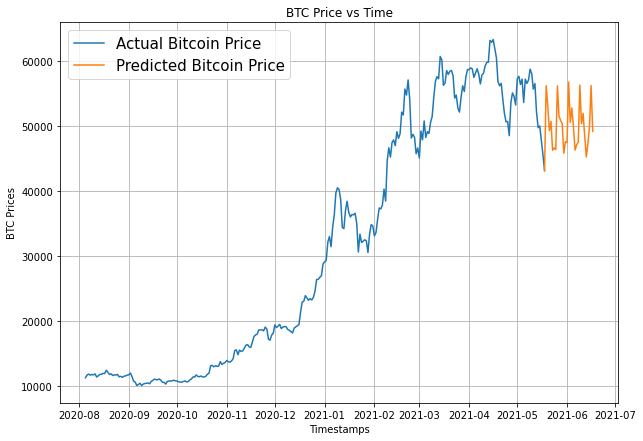

In [227]:
plt.figure(figsize=(10, 7))
plot_time_series_graph(price.index, price.Price, start=2500, format="-", label="Actual Bitcoin Price")
plot_time_series_graph(next_time_steps, future_forecast[:31], format="-", label="Predicted Bitcoin Price")

<AxesSubplot:>

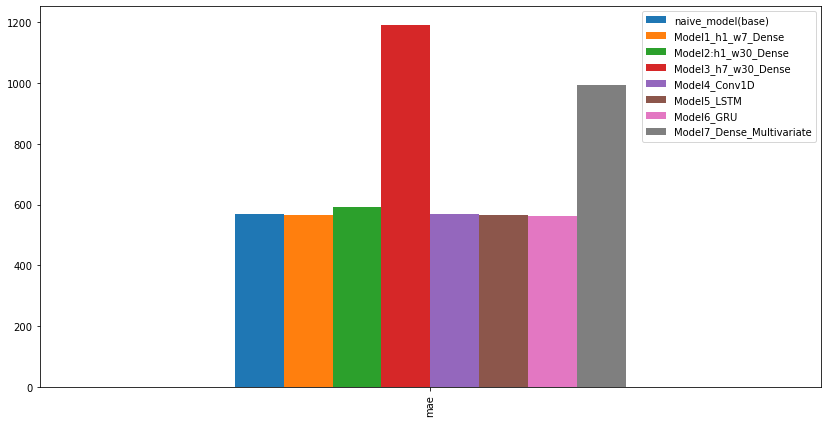

In [229]:
pd.DataFrame({"naive_model(base)":naive_results["mae"],
              "Model1_h1_w7_Dense":model_1_results["mae"],
              "Model2:h1_w30_Dense":model_2_results["mae"],
              "Model3_h7_w30_Dense":model_3_results["mae"],
              "Model4_Conv1D":model_4_results["mae"],
              "Model5_LSTM":model_5_results["mae"],
              "Model6_GRU":model_6_results["mae"],
              "Model7_Dense_Multivariate":model_7_results["mae"],
              },index=["mae"]).plot(figsize=(14,7),kind="bar")

In [238]:
model_results=pd.DataFrame({"naive_model(base_model)":naive_results,
                            "model_1_dense(w7_h1)":model_1_results,
                            "model_2_dense(w30_h1)":model_2_results,
                            "model_3_dense(w30,h7)":model_3_results,
                            "model_4_Conv1D":model_4_results,
                            "model_5_LSTM":model_5_results,
                            "model_6_GRU":model_6_results,
                            "model_7_Dense_multivariate":model_7_results,
                            "model_8_tribrid":model_8_results,
                            }).T
model_results
model_results.to_csv("Model Results.csv",index_label="Models")

In [240]:
pd.read_csv("Model Results.csv")

,Models,mae,mse,rmse,mape,mase
0,naive_model(base_model),567.98020,1147547.0,1071.2362,2.516525,0.999570
1,model_1_dense(w7_h1),564.42960,1146537.4,1070.7649,2.519920,0.991546
2,model_2_dense(w30_h1),590.48790,1226906.0,1107.6578,2.737607,1.032179
3,"model_3_dense(w30,h7)",1192.06920,5004384.5,1378.3088,5.496029,2.121220
4,model_4_Conv1D,568.50810,1171916.9,1082.5510,2.547414,0.998711
5,model_5_LSTM,566.45800,1167174.0,1080.3583,2.543389,0.995110
6,model_6_GRU,563.34033,1156491.5,1075.4030,2.524413,0.989633
7,model_7_Dense_multivariate,993.42560,3291787.5,1814.3284,4.479973,1.745174
8,model_8_tribrid,17132.17200,616878660.0,23774.6540,113.176980,30.096485


<AxesSubplot:>

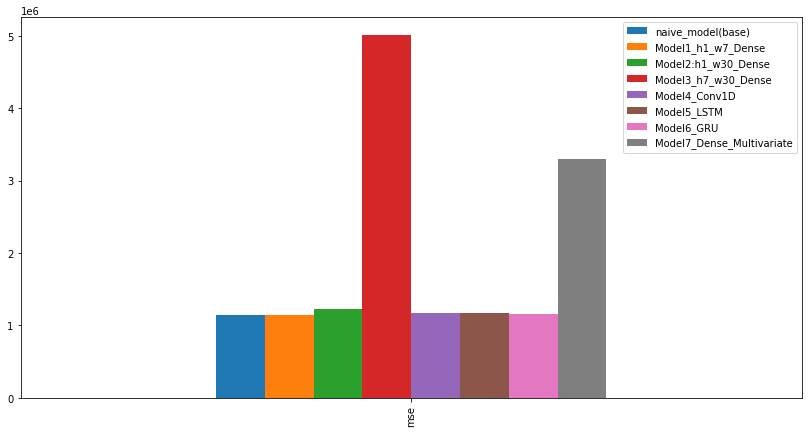

In [244]:
pd.DataFrame({"naive_model(base)":naive_results["mse"],
              "Model1_h1_w7_Dense":model_1_results["mse"],
              "Model2:h1_w30_Dense":model_2_results["mse"],
              "Model3_h7_w30_Dense":model_3_results["mse"],
              "Model4_Conv1D":model_4_results["mse"],
              "Model5_LSTM":model_5_results["mse"],
              "Model6_GRU":model_6_results["mse"],
              "Model7_Dense_Multivariate":model_7_results["mse"],
              },index=["mse"]).plot(figsize=(14,7),kind="bar")